# Deep Convolutional Generative Adversarial Network

fuente: https://www.tensorflow.org/tutorials/generative/dcgan


Este tutorial demuestra cómo generar imágenes de dígitos utilizando
[Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). El código utiliza 
[Keras Sequential API](https://www.tensorflow.org/guide/keras) con `tf.GradientTape` para el bucle de entrenamiento.

## Qué son GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) son dos modelos que se entrenan simultáneamente en un proceso 'adversarial' o'antagonista'. Un generador aprende a crear imágenes que se ven reales, mientras un discriminador aprende a distinguir imágenes reales de falsas.


![Diagrama de generador y discriminador](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

Durante el entrenamiento el generador se vuelve progresivamente mejor en crear imágenes que se ven reales, mientras el discriminador se vuelve mejor en distinguir. El proceso encuentra un punto de equilibrio cuando el discriminador no puede distinguir entre imágenes reales y falsas.

![Segundo diagrama de generador y discriminador](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

Acá se va a demostrar con MNIST. La animación que sigue muestra el proceso de mejora del generador a medida que se entrena durante 50 epochs. Al principio los ejemplos generados son prácticamente aleatorios y luego van mejorando.


![ejemplo de salida](https://tensorflow.org/images/gan/dcgan.gif)


### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
# para generar GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-2fzacty0
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-2fzacty0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0ab165fda010d80d82548b3797c1eaaf5803a00e8_-py3-none-any.whl size=154264 sha256=b6527a431ce2be843af4cd215d4a3706929777f789f7c333b5d123120b9b694b
  Stored in directory: /tmp/pip-ephem-wheel-cache-wgo4xwwf/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Cargar y preparar el dataset


In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalizar las imágenes a [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# mezclar los datos y separarlos en batches
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Crear los modelos

Se crean los modelos usando keras.


### El generador

El generador usa `tf.keras.layers.Conv2DTranspose` haciendo capas de upsampling para producir una imágen de una ruido 'semilla'. Se empieza con una capa 
`Dense` que toma la 'semilla' como entrada y le hace upsample hasta que se obtiene el tamaño deseado de 28x28x1. Notar que se usa `tf.keras.layers.LeakyReLU` como activación en cada capa, excepto la capa de salida que usa tanh.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Utilizar el generador sin entrenar para generar una imágen.

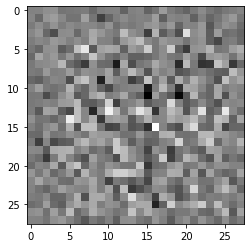

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El discriminador

El discriminador es un clasificador de imágenes que usa una red convolucional.

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Utilizar el discriminador sin entrenar para clasificar una imágen generada. El modelo entrenado debería retornar valores negativos para imágenes falsas y valores positivos para imágenes reales.


In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00210334]], shape=(1, 1), dtype=float32)


## Definir la función de costo y optimizadores para ambos modelos



In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Costo del discriminador

Este método cuantifica cuán bien consigue distinguir el discriminador una imagen real de una falsa. Compara las predicciones del discriminador en imágenes reales (debe devolver 1) y en imágenes falsas (debe devolver 0)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Función de costo del generador

La función de costo del generador cuantifica cuán bien el generador consigue engañar al discriminador. Intuitivamente, el generador está haciendo bien su trabajo cuando el discriminador clasifica imágenes falsas como verdaderas. Comparamos la salida del discriminador en imágenes falsas con un array de unos.


In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores para el discriminador y el generador son diferentes porque vamos a entrenar las redes por separado.




In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Salvar los checkpoints


In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Bucle de entrenamiento


In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

El bucle comienza con el generador que recibe una 'semilla' aleatoria como entrada. Esa 'semilla' produce una imagen. El discriminador es entonces usado para clasificar imágenes reales (obtenidas de un set de entrenamiento) e imágenes falsas (producidas por el generador). La función de costo es calculada para cada uno de estos modelos, y los gradientes on usados para actualizar el generador y el discriminador.


In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Producir imágenes para el gif
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # salvar el modelo cada 15 épocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # generar imágen al fin de cada época
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generar y guardar imágenes**


In [21]:
def generate_and_save_images(model, epoch, test_input):
  # 'training' esta seteado en falso de tal manera
  # que las capas corren en modo inferencia
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Entrenar el modelo

Hay que llamar al método `train()` para entrenar al generador y al discriminador simultáneamente. Notar que entrenar GANs puede ser difícil. Es importante que el generador y discriminador sean parecidos en 'potencia' y que aprendan a una velocidad similar.

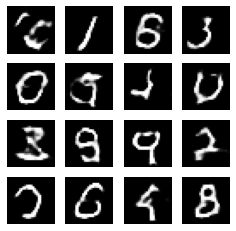

In [22]:
train(train_dataset, EPOCHS)

Recuperar el último checkpoint.

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generar GIF


In [24]:

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

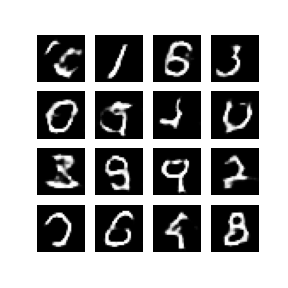

In [25]:
display_image(EPOCHS)

Utilizar `imageio` para crear un gif animado utilizando las imágenes guardadas durante el entrenamiento.

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


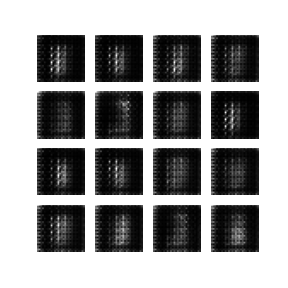

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)